In [1]:
# ============================================================================
# 03_modeling.ipynb
# Model Training and Evaluation for Multi-Class Diabetes Classification
# Dataset: BRFSS 2015 - Diabetes Health Indicators (3 Classes)
# 
# OPTIMIZATION GOAL: HIGH RECALL
# Medical Context: In diabetes screening, it is more important to identify
# all potential diabetes cases (high recall) even if it means some false 
# positives. Missing a diabetes case (false negative) has more serious 
# health consequences than a false alarm (false positive).
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path to import custom modules
sys.path.append('../src/core')

# Import custom modules for feature engineering and modeling
from feature_engineering import apply_all_feature_engineering  # noqa: E402
from modeling import (  # noqa: E402
    train_logistic_regression,
    train_random_forest,
    train_xgboost,
    train_linear_svm,
    evaluate_model,
    plot_confusion_matrix,
    plot_classification_report,
    plot_roc_curves,
    compare_models,
    save_model
)

# Scikit-learn imports for scaling
from sklearn.preprocessing import StandardScaler  # noqa: E402

# Configure plot style for consistent visualizations
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Define output directories for saving visualizations and models
output_dir = "../outputs/figures/modeling"
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created: {output_dir}")

models_dir = "../outputs/models"
os.makedirs(models_dir, exist_ok=True)
print(f"Models directory created: {models_dir}")


Output directory created: ../outputs/figures/modeling
Models directory created: ../outputs/models


# Load Preprocessed Data

In [2]:
# =============================================================================
# 1. LOAD PREPROCESSED DATA
# =============================================================================
print("\n" + "="*80)
print("STEP 1: LOAD PREPROCESSED DATA")
print("="*80)

# Load scaled training and test data
# These datasets have continuous features scaled (StandardScaler)
# Binary and ordinal features remain unchanged
features_train = pd.read_csv("../data/processed/features_train_scaled.csv")
features_test = pd.read_csv("../data/processed/features_test_scaled.csv")

# Load target variables
# squeeze() converts single-column DataFrame to Series
target_train = pd.read_csv("../data/processed/target_train.csv").squeeze()
target_test = pd.read_csv("../data/processed/target_test.csv").squeeze()

# Load SMOTE-resampled training data
# SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic samples
# for minority classes to balance the dataset
features_train_smote = pd.read_csv("../data/processed/features_train_smote.csv")
target_train_smote = pd.read_csv("../data/processed/target_train_smote.csv").squeeze()

# Display data shapes to verify successful loading
print("\nDATA SHAPES:")
print("-" * 60)
print(f"Training Set (Original):     {features_train.shape}")
print(f"Training Set (SMOTE):        {features_train_smote.shape}")
print(f"Test Set:                    {features_test.shape}")

# Display target distribution to understand class imbalance
# Class 0 = No Diabetes
# Class 1 = Prediabetes
# Class 2 = Diabetes
print("\nTARGET DISTRIBUTION:")
print("-" * 60)
print("Training Set (Original):")
print(target_train.value_counts().sort_index()) # pyright: ignore[reportAttributeAccessIssue]
print("\nTraining Set (SMOTE):")
print(target_train_smote.value_counts().sort_index()) # pyright: ignore[reportAttributeAccessIssue]
print("\nTest Set:")
print(target_test.value_counts().sort_index()) # pyright: ignore[reportAttributeAccessIssue]



STEP 1: LOAD PREPROCESSED DATA

DATA SHAPES:
------------------------------------------------------------
Training Set (Original):     (183824, 21)
Training Set (SMOTE):        (456129, 21)
Test Set:                    (45957, 21)

TARGET DISTRIBUTION:
------------------------------------------------------------
Training Set (Original):
Diabetes_012
0.0    152043
1.0      3703
2.0     28078
Name: count, dtype: int64

Training Set (SMOTE):
Diabetes_012
0.0    152043
1.0    152043
2.0    152043
Name: count, dtype: int64

Test Set:
Diabetes_012
0.0    38012
1.0      926
2.0     7019
Name: count, dtype: int64


# Feature Engineering

In [3]:
# =============================================================================
# 2. FEATURE ENGINEERING
# =============================================================================
print("\n" + "="*80)
print("STEP 2: FEATURE ENGINEERING")
print("="*80)

print("\nAPPLYING FEATURE ENGINEERING:")
print("-" * 60)
print("Creating new features:")
print("  • HealthRiskScore: Sum of risk factors (HighBP, HighChol, Stroke, etc.)")
print("  • LifestyleScore: Sum of positive health habits (PhysActivity, Fruits, Veggies)")
print("  • BMI Categories: One-hot encoded BMI groups (Underweight, Normal, Overweight, Obese)")
print("  • Age Groups: One-hot encoded age groups (Young, Middle, Senior)")
print("  • Interaction Features: Product of related features (BMI×HighBP, Age×BMI, GenHlth×PhysActivity)")

# Apply feature engineering to all three datasets
# This creates composite features that may have better predictive power
# than individual features alone
features_train_eng = apply_all_feature_engineering(features_train)
features_test_eng = apply_all_feature_engineering(features_test)
features_train_smote_eng = apply_all_feature_engineering(features_train_smote)

# Display feature engineering results
print("\nFeature engineering completed")
print(f"Original features:  {features_train.shape[1]}")
print(f"Engineered features: {features_train_eng.shape[1]}")
print(f"New features added:  {features_train_eng.shape[1] - features_train.shape[1]}")



STEP 2: FEATURE ENGINEERING

APPLYING FEATURE ENGINEERING:
------------------------------------------------------------
Creating new features:
  • HealthRiskScore: Sum of risk factors (HighBP, HighChol, Stroke, etc.)
  • LifestyleScore: Sum of positive health habits (PhysActivity, Fruits, Veggies)
  • BMI Categories: One-hot encoded BMI groups (Underweight, Normal, Overweight, Obese)
  • Age Groups: One-hot encoded age groups (Young, Middle, Senior)
  • Interaction Features: Product of related features (BMI×HighBP, Age×BMI, GenHlth×PhysActivity)
Feature engineering completed. New shape: (183824, 33)
Feature engineering completed. New shape: (45957, 33)
Feature engineering completed. New shape: (456129, 33)

Feature engineering completed
Original features:  21
Engineered features: 33
New features added:  12


# Scale New Continuous Features

In [4]:
# =============================================================================
# 3. SCALE NEW CONTINUOUS FEATURES
# =============================================================================
print("\n" + "="*80)
print("STEP 3: SCALE NEW CONTINUOUS FEATURES")
print("="*80)

# Identify new continuous features that need scaling
# These are the newly created features that have continuous values
# Scaling ensures all features have similar ranges (mean=0, std=1)
new_continuous_features = ['HealthRiskScore', 'LifestyleScore', 'BMI_x_HighBP', 
                           'Age_x_BMI', 'GenHlth_x_PhysActivity']

print("\nSCALING NEW CONTINUOUS FEATURES:")
print("-" * 60)
print(f"Features to scale: {new_continuous_features}")

# Initialize StandardScaler for new features
# StandardScaler: (x - mean) / std
scaler_new = StandardScaler()

# Fit scaler on training data and transform training set
# fit_transform() calculates mean and std from training data
features_train_eng[new_continuous_features] = scaler_new.fit_transform(
    features_train_eng[new_continuous_features]
)

# Transform test set using training statistics
# Important: Use transform() only (not fit_transform()) to avoid data leakage
features_test_eng[new_continuous_features] = scaler_new.transform(
    features_test_eng[new_continuous_features]
)

# Transform SMOTE training set using same statistics
# This ensures consistency across all datasets
features_train_smote_eng[new_continuous_features] = scaler_new.transform(
    features_train_smote_eng[new_continuous_features]
)

print("\nNew continuous features scaled")



STEP 3: SCALE NEW CONTINUOUS FEATURES

SCALING NEW CONTINUOUS FEATURES:
------------------------------------------------------------
Features to scale: ['HealthRiskScore', 'LifestyleScore', 'BMI_x_HighBP', 'Age_x_BMI', 'GenHlth_x_PhysActivity']

New continuous features scaled


# Model Training

In [5]:
# =============================================================================
# 4. MODEL TRAINING - BASELINE (WITHOUT SMOTE) - OPTIMIZED FOR RECALL
# =============================================================================
from sklearn.model_selection import train_test_split

print("\n" + "="*80)
print("STEP 4: MODEL TRAINING - BASELINE (WITHOUT SMOTE)")
print("OPTIMIZATION: HIGH RECALL FOR MEDICAL SCREENING")
print("="*80)

print("\nMEDICAL CONTEXT:")
print("-" * 60)
print("In diabetes screening, HIGH RECALL is critical because:")
print("  • Missing a diabetes case (False Negative) can lead to serious health complications")
print("  • False alarms (False Positives) can be verified with follow-up tests")
print("  • Early detection saves lives and reduces treatment costs")
print("  • It's better to screen more people than to miss actual cases")

print("\nTRAINING BASELINE MODELS (RECALL-OPTIMIZED):")
print("-" * 60)

# Initialize dictionaries to store models and results
models_baseline = {}
results_baseline = {}

# 4.1 Logistic Regression
print("\n[1/4] Training Logistic Regression (Recall-Optimized)...")
print("      • Using class_weight='balanced' to prioritize minority classes")
print("      • Linear model with L2 regularization (C=1.0)")
print("      • Max iterations: 1000 for convergence")
lr_model = train_logistic_regression(features_train_eng, target_train) # pyright: ignore[reportArgumentType]
models_baseline['Logistic Regression'] = lr_model
results_baseline['Logistic Regression'] = evaluate_model(
    lr_model, features_test_eng, target_test # pyright: ignore[reportArgumentType]
)
print(f"      Recall: {results_baseline['Logistic Regression']['Recall']:.4f}")

# 4.2 Random Forest
print("\n[2/4] Training Random Forest (Recall-Optimized)...")
print("      • Using class_weight='balanced' to prioritize minority classes")
print("      • Ensemble of 100 decision trees")
print("      • Max depth: 10 to prevent overfitting")
print("      • Random state: 42 for reproducibility")
rf_model = train_random_forest(features_train_eng, target_train) # pyright: ignore[reportArgumentType]
models_baseline['Random Forest'] = rf_model
results_baseline['Random Forest'] = evaluate_model(
    rf_model, features_test_eng, target_test # pyright: ignore[reportArgumentType]
)
print(f"      Recall: {results_baseline['Random Forest']['Recall']:.4f}")

# 4.3 XGBoost
print("\n[3/4] Training XGBoost (Recall-Optimized)...")
print("      • Using scale_pos_weight to balance classes")
print("      • Gradient boosting with 100 estimators")
print("      • Learning rate: 0.1")
print("      • Max depth: 5")
print("      • Optimized for multi-class classification")
xgb_model = train_xgboost(features_train_eng, target_train) # pyright: ignore[reportArgumentType]
models_baseline['XGBoost'] = xgb_model
results_baseline['XGBoost'] = evaluate_model(
    xgb_model, features_test_eng, target_test # pyright: ignore[reportArgumentType]
)
print(f"      Recall: {results_baseline['XGBoost']['Recall']:.4f}")

# 4.4 LinearSVM (on 10% sample for speed)
print("\n[4/4] Training LinearSVM (Recall-Optimized) - ON 10% SAMPLE...")
print("      LinearSVM trained on 10% sample for computational efficiency")
print("      • Full dataset training would take significant time")
print("      • Sample training provides performance estimate")
print("      • Using class_weight='balanced' to prioritize minority classes")
print("      • Linear kernel (much faster than RBF)")
print("      • Calibrated for probability estimates")

# Sample 10% of training data for LinearSVM
features_train_sample, _, target_train_sample, _ = train_test_split(
    features_train_eng, target_train, 
    train_size=0.1, 
    random_state=42, 
    stratify=target_train # pyright: ignore[reportArgumentType]
)

print(f"      • Training on {len(features_train_sample):,} samples (10% of {len(features_train_eng):,})")

svm_model = train_linear_svm(features_train_sample, target_train_sample) 
models_baseline['LinearSVM (10%)'] = svm_model
results_baseline['LinearSVM (10%)'] = evaluate_model(
    svm_model, features_test_eng, target_test # pyright: ignore[reportArgumentType]
)
print(f"      Recall: {results_baseline['LinearSVM (10%)']['Recall']:.4f}")
print("      Note: Results based on 10% sample, not full training data")

print("\nBaseline models trained successfully")
print("All models optimized for HIGH RECALL to minimize false negatives")



STEP 4: MODEL TRAINING - BASELINE (WITHOUT SMOTE)
OPTIMIZATION: HIGH RECALL FOR MEDICAL SCREENING

MEDICAL CONTEXT:
------------------------------------------------------------
In diabetes screening, HIGH RECALL is critical because:
  • Missing a diabetes case (False Negative) can lead to serious health complications
  • False alarms (False Positives) can be verified with follow-up tests
  • Early detection saves lives and reduces treatment costs
  • It's better to screen more people than to miss actual cases

TRAINING BASELINE MODELS (RECALL-OPTIMIZED):
------------------------------------------------------------

[1/4] Training Logistic Regression (Recall-Optimized)...
      • Using class_weight='balanced' to prioritize minority classes
      • Linear model with L2 regularization (C=1.0)
      • Max iterations: 1000 for convergence
      Recall: 0.6279

[2/4] Training Random Forest (Recall-Optimized)...
      • Using class_weight='balanced' to prioritize minority classes
      • Ens

# Model Training with SMOTE

In [6]:
# =============================================================================
# 5. MODEL TRAINING - WITH SMOTE - OPTIMIZED FOR RECALL
# =============================================================================
print("\n" + "="*80)
print("STEP 5: MODEL TRAINING - WITH SMOTE")
print("OPTIMIZATION: HIGH RECALL + BALANCED CLASSES")
print("="*80)

print("\nSMOTE BENEFITS:")
print("-" * 60)
print("SMOTE (Synthetic Minority Over-sampling Technique) helps by:")
print("  • Creating synthetic samples for minority classes (Prediabetes, Diabetes)")
print("  • Balancing class distribution in training data")
print("  • Improving model's ability to learn patterns in minority classes")
print("  • Further boosting recall for underrepresented classes")
print("  • Reducing bias towards majority class (No Diabetes)")

print("\nTRAINING MODELS WITH SMOTE (RECALL-OPTIMIZED):")
print("-" * 60)

# Initialize dictionaries for SMOTE models and results
models_smote = {}
results_smote = {}

# 5.1 Logistic Regression with SMOTE
print("\n[1/4] Training Logistic Regression (SMOTE + Recall-Optimized)...")
print("      • Training on SMOTE-balanced dataset")
print("      • class_weight='balanced' for additional emphasis on minorities")
print("      • Expected: Higher recall for Prediabetes and Diabetes")
lr_model_smote = train_logistic_regression(features_train_smote_eng, target_train_smote) # pyright: ignore[reportArgumentType]
models_smote['Logistic Regression'] = lr_model_smote
results_smote['Logistic Regression'] = evaluate_model(
    lr_model_smote, features_test_eng, target_test # pyright: ignore[reportArgumentType]
)
print(f"      Recall: {results_smote['Logistic Regression']['Recall']:.4f}")

# 5.2 Random Forest with SMOTE
print("\n[2/4] Training Random Forest (SMOTE + Recall-Optimized)...")
print("      • Training on SMOTE-balanced dataset")
print("      • class_weight='balanced' for additional emphasis")
print("      • 100 trees with max_depth=10")
print("      • Expected: Improved minority class detection")
rf_model_smote = train_random_forest(features_train_smote_eng, target_train_smote) # pyright: ignore[reportArgumentType]
models_smote['Random Forest'] = rf_model_smote
results_smote['Random Forest'] = evaluate_model(
    rf_model_smote, features_test_eng, target_test # pyright: ignore[reportArgumentType]
)
print(f"      Recall: {results_smote['Random Forest']['Recall']:.4f}")

# 5.3 XGBoost with SMOTE
print("\n[3/4] Training XGBoost (SMOTE + Recall-Optimized)...")
print("      • Training on SMOTE-balanced dataset")
print("      • scale_pos_weight for additional class balancing")
print("      • Gradient boosting optimized for recall")
print("      • Expected: Best overall recall performance")
xgb_model_smote = train_xgboost(features_train_smote_eng, target_train_smote) # pyright: ignore[reportArgumentType]
models_smote['XGBoost'] = xgb_model_smote
results_smote['XGBoost'] = evaluate_model(
    xgb_model_smote, features_test_eng, target_test # pyright: ignore[reportArgumentType]
)
print(f"      Recall: {results_smote['XGBoost']['Recall']:.4f}")

# 5.4 LinearSVM with SMOTE (on 10% sample for speed)
print("\n[4/4] Training LinearSVM (SMOTE + Recall-Optimized) - ON 10% SAMPLE...")
print("      LinearSVM trained on 10% SMOTE sample for computational efficiency")
print("      • Training on SMOTE-balanced dataset (10% sample)")
print("      • class_weight='balanced' for additional emphasis")
print("      • Linear kernel for fast training")
print("      • Expected: Improved recall with balanced classes")

# Sample 10% of SMOTE training data for LinearSVM
features_train_smote_sample, _, target_train_smote_sample, _ = train_test_split(
    features_train_smote_eng, target_train_smote, 
    train_size=0.1, 
    random_state=42, 
    stratify=target_train_smote # pyright: ignore[reportArgumentType]
)

print(f"      • Training on {len(features_train_smote_sample):,} samples (10% of {len(features_train_smote_eng):,})")

svm_model_smote = train_linear_svm(features_train_smote_sample, target_train_smote_sample)
models_smote['LinearSVM (10%)'] = svm_model_smote
results_smote['LinearSVM (10%)'] = evaluate_model(
    svm_model_smote, features_test_eng, target_test # pyright: ignore[reportArgumentType]
)
print(f"      Recall: {results_smote['LinearSVM (10%)']['Recall']:.4f}")
print("      Note: Results based on 10% SMOTE sample")

print("\nSMOTE models trained successfully")
print("  All models benefit from balanced training data + recall optimization")



STEP 5: MODEL TRAINING - WITH SMOTE
OPTIMIZATION: HIGH RECALL + BALANCED CLASSES

SMOTE BENEFITS:
------------------------------------------------------------
SMOTE (Synthetic Minority Over-sampling Technique) helps by:
  • Creating synthetic samples for minority classes (Prediabetes, Diabetes)
  • Balancing class distribution in training data
  • Improving model's ability to learn patterns in minority classes
  • Further boosting recall for underrepresented classes
  • Reducing bias towards majority class (No Diabetes)

TRAINING MODELS WITH SMOTE (RECALL-OPTIMIZED):
------------------------------------------------------------

[1/4] Training Logistic Regression (SMOTE + Recall-Optimized)...
      • Training on SMOTE-balanced dataset
      • class_weight='balanced' for additional emphasis on minorities
      • Expected: Higher recall for Prediabetes and Diabetes
      Recall: 0.6243

[2/4] Training Random Forest (SMOTE + Recall-Optimized)...
      • Training on SMOTE-balanced dataset


# Visualize Confusion Matrices (Baseline)


STEP 6: CONFUSION MATRICES - BASELINE MODELS

GENERATING CONFUSION MATRICES:
------------------------------------------------------------
Confusion matrices show:
  • True Positives (TP): Correctly identified diabetes cases
  • False Negatives (FN): Missed diabetes cases (CRITICAL TO MINIMIZE)
  • False Positives (FP): False alarms (acceptable in medical screening)
  • True Negatives (TN): Correctly identified non-diabetes cases


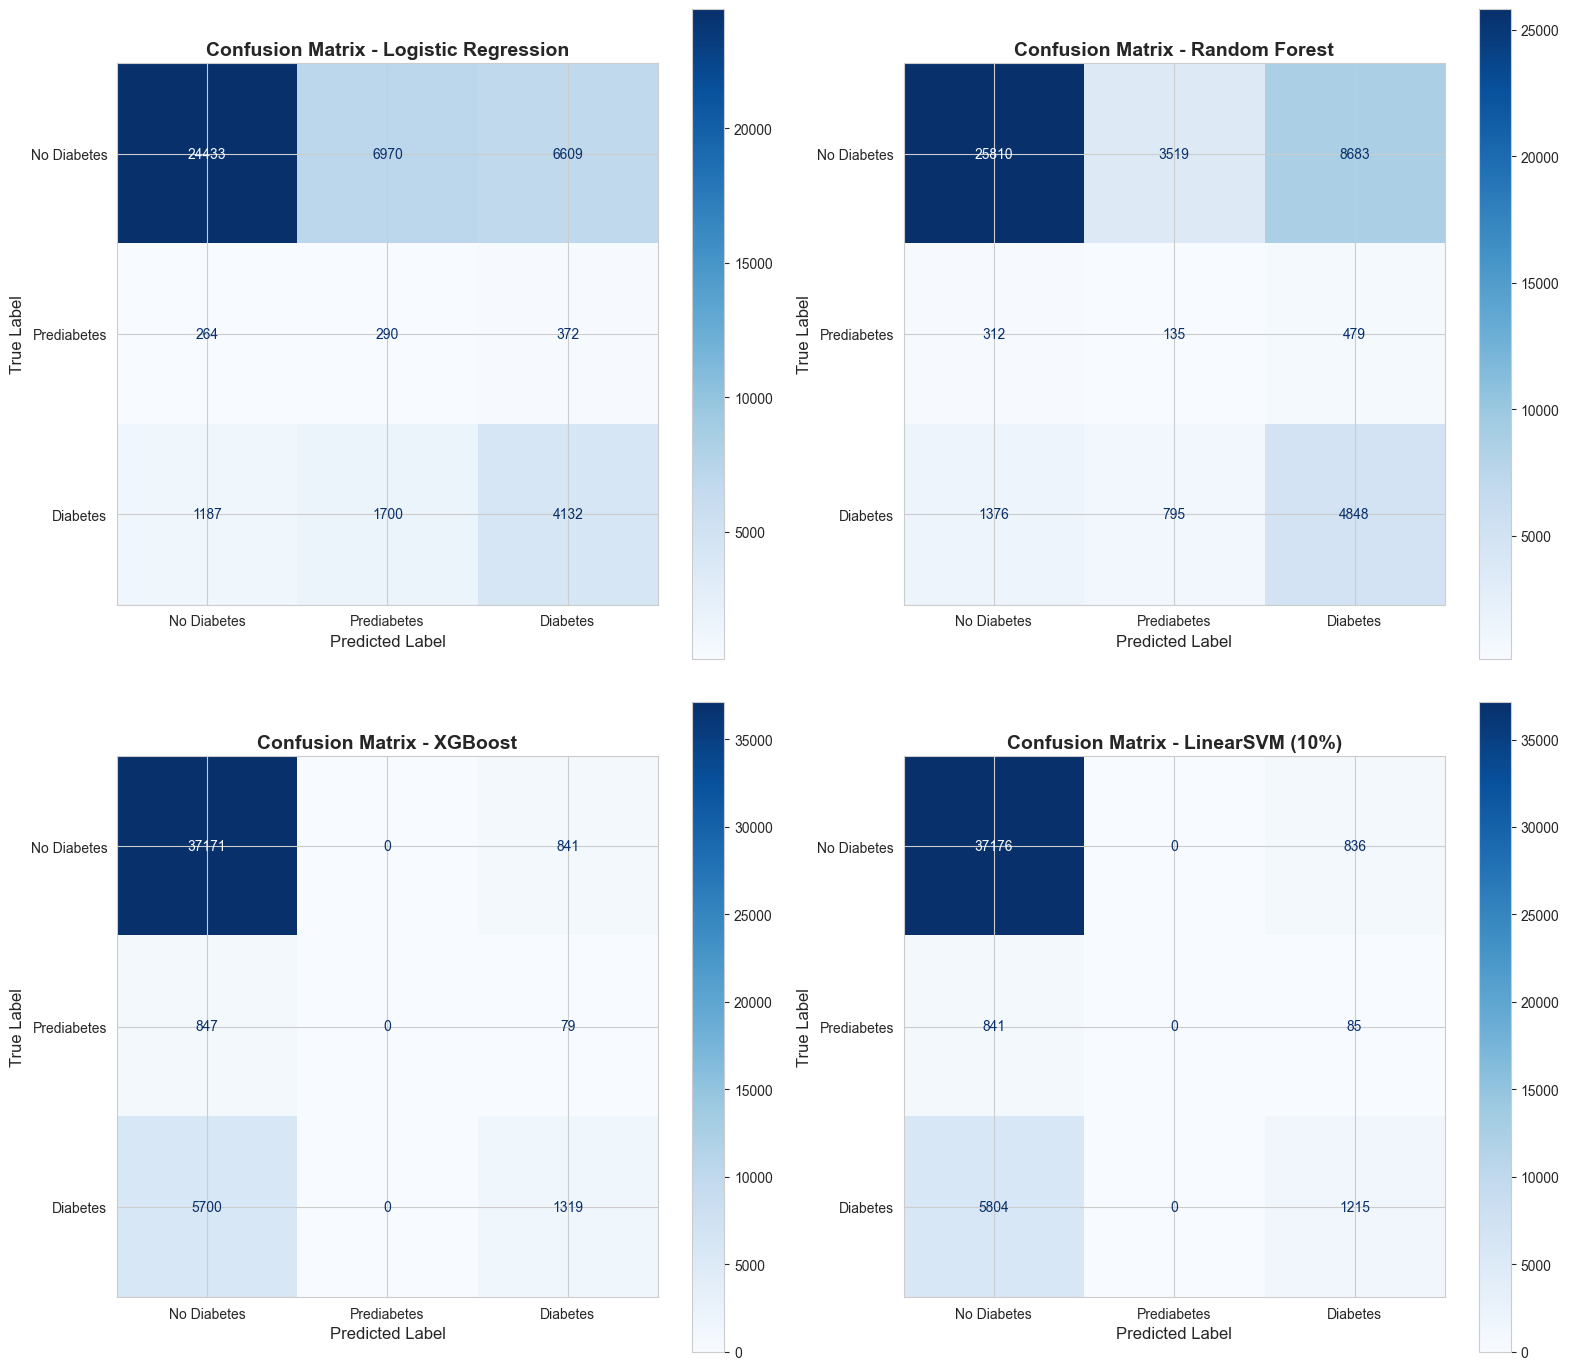


Saved: ../outputs/figures/modeling/01_confusion_matrices_baseline.png


In [8]:
# =============================================================================
# 6. VISUALIZE CONFUSION MATRICES - BASELINE
# =============================================================================
print("\n" + "="*80)
print("STEP 6: CONFUSION MATRICES - BASELINE MODELS")
print("="*80)

print("\nGENERATING CONFUSION MATRICES:")
print("-" * 60)
print("Confusion matrices show:")
print("  • True Positives (TP): Correctly identified diabetes cases")
print("  • False Negatives (FN): Missed diabetes cases (CRITICAL TO MINIMIZE)")
print("  • False Positives (FP): False alarms (acceptable in medical screening)")
print("  • True Negatives (TN): Correctly identified non-diabetes cases")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, (model_name, model) in enumerate(models_baseline.items()):
    plot_confusion_matrix(
        model, 
        features_test_eng, 
        target_test,  # pyright: ignore[reportArgumentType]
        model_name, 
        ax=axes[idx]
    )

plt.tight_layout()
plt.savefig(f"{output_dir}/01_confusion_matrices_baseline.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {output_dir}/01_confusion_matrices_baseline.png")


# Visualize Confusion Matrices (SMOTE)


STEP 7: CONFUSION MATRICES - SMOTE MODELS

GENERATING CONFUSION MATRICES (SMOTE):
------------------------------------------------------------


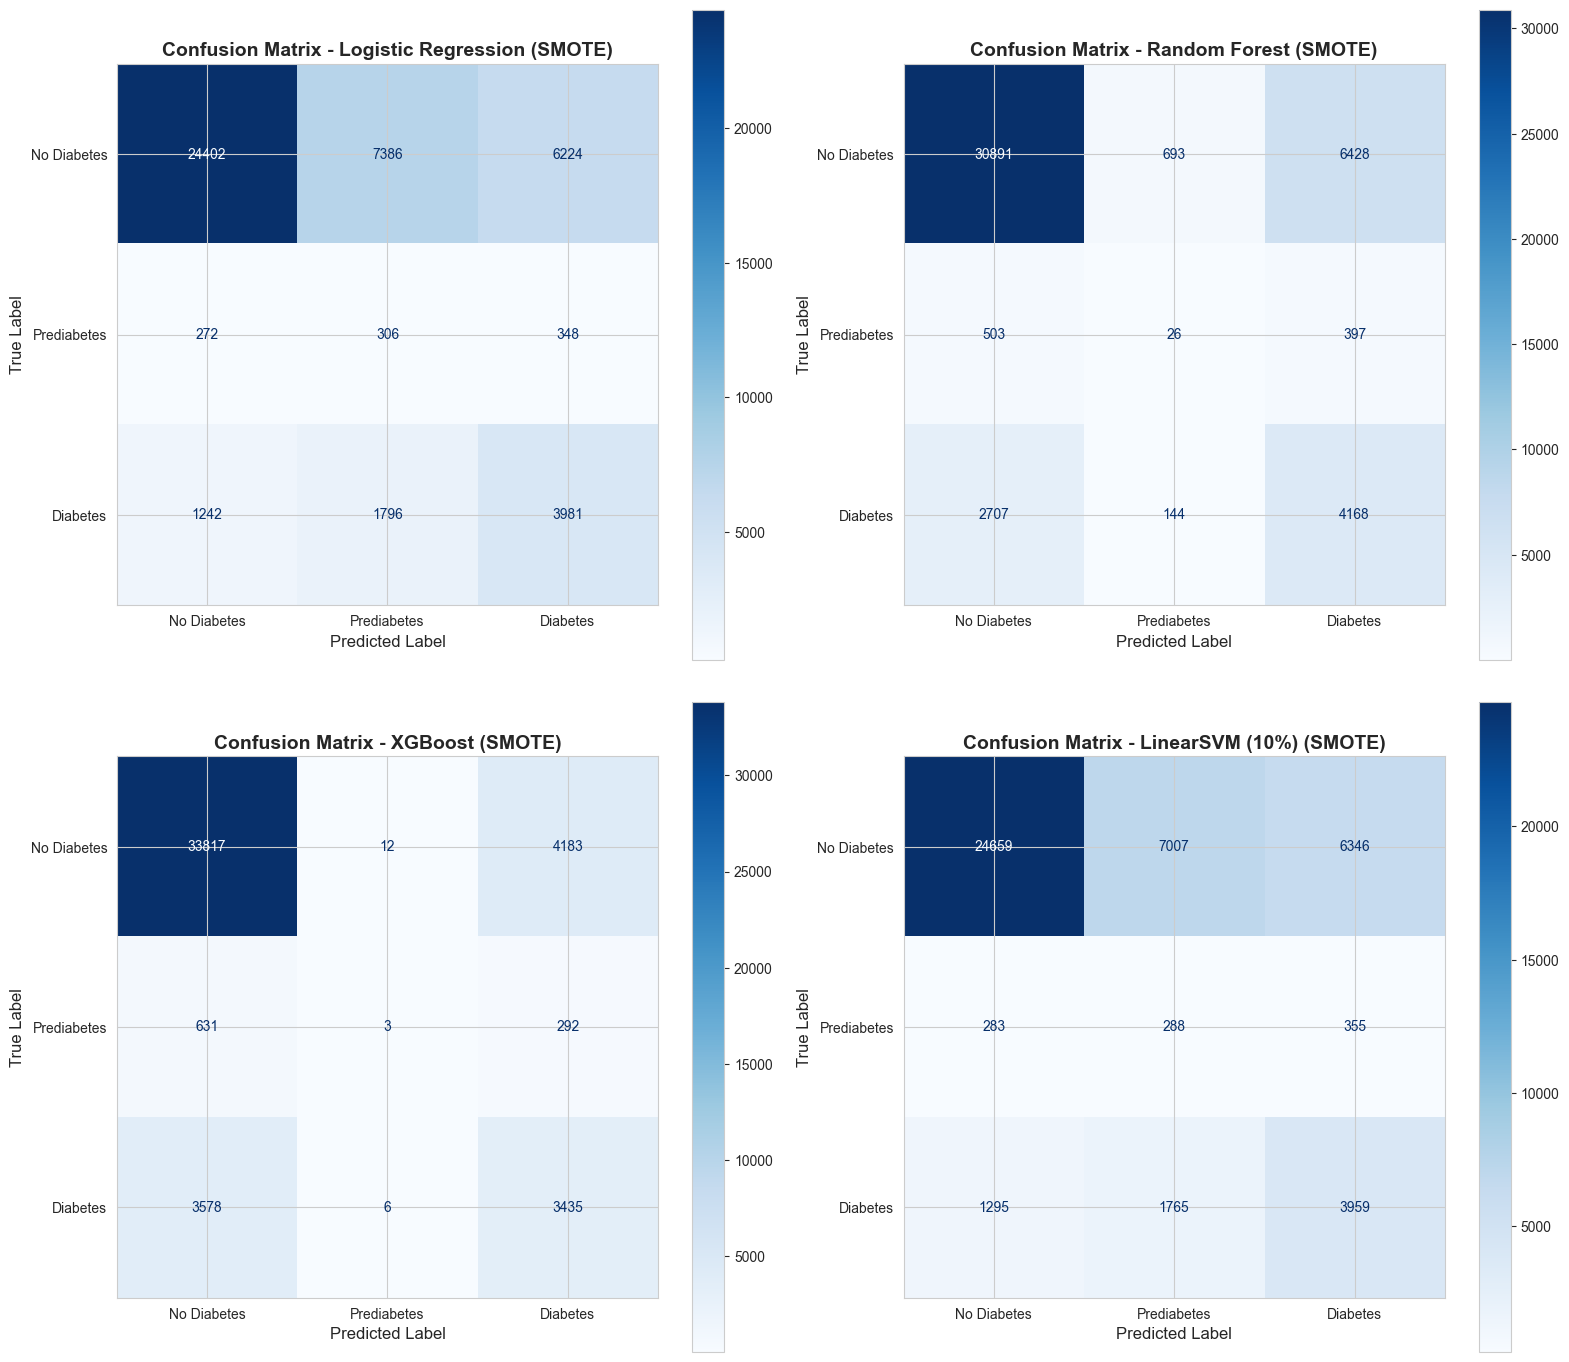


Saved: ../outputs/figures/modeling/02_confusion_matrices_smote.png


In [9]:
# =============================================================================
# 7. VISUALIZE CONFUSION MATRICES - SMOTE
# =============================================================================
print("\n" + "="*80)
print("STEP 7: CONFUSION MATRICES - SMOTE MODELS")
print("="*80)

print("\nGENERATING CONFUSION MATRICES (SMOTE):")
print("-" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, (model_name, model) in enumerate(models_smote.items()):
    plot_confusion_matrix(
        model, 
        features_test_eng, 
        target_test,  # pyright: ignore[reportArgumentType]
        f"{model_name} (SMOTE)", 
        ax=axes[idx]
    )

plt.tight_layout()
plt.savefig(f"{output_dir}/02_confusion_matrices_smote.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {output_dir}/02_confusion_matrices_smote.png")
